In [1]:
from code.dataviz import data_slice,data_timeplot, mape, smape, savefig
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta

# PROPHET MODEL for solving dynamic profile forecasting challenge

In [2]:
from fbprophet import Prophet
import numpy as np

In [3]:

X_train=pd.read_csv('..\\..\\..\\datasets\\training_input_qFI2jug.csv', index_col="Horodate_UTC",parse_dates=['Horodate_UTC'],dayfirst=True)
feature_list=list(X_train.columns[3:])
#X_train['timestamp']=pd.to_datetime(X_train.index)
X_train.index = pd.DatetimeIndex(X_train.index)

liste_dates = X_train.index.tolist()
for dt in liste_dates :
    X_train.at[dt, 'sort'] = dt.strftime('%m%d%H%S')

X_train['sort'].astype(int)

df_month = X_train.sort_values(by='sort', ascending=True)
df_month.head(20)
df_month = df_month.interpolate(str="linear", axis=0).ffill().bfill()
df = df_month.sort_values(by='IDS', ascending=True)

X_train.drop('sort', axis=1)

X_train['Pseudo rayonnement'] = df['Pseudo rayonnement']
X_train['timestamp']=pd.to_datetime(X_train.index)

In [4]:
X_test=pd.read_csv('..\\..\\..\\datasets\\testing_input_BcjTmnd.csv',index_col="Horodate_UTC",parse_dates=['Horodate_UTC'],dayfirst=True)
#X_test['timestamp']=pd.to_datetime(X_test.index)
X_test.index = pd.DatetimeIndex(X_test.index)

X_test['timestamp']=pd.to_datetime(X_test.index)

In [5]:
y_train=pd.read_csv('..\\..\\..\\datasets\\training_output_uamzSZW.csv',index_col="Horodate_UTC",parse_dates=['Horodate_UTC'],dayfirst=True)
#y_train['timestamp']=pd.to_datetime(y_train.index)
y_train.index = pd.DatetimeIndex(y_train.index)

y_train['timestamp']=pd.to_datetime(y_train.index)

# dataset preparation for prophet interface

Prophet model requires a minimum of 2 columns matching the timeserie strucuture :
- column 'ds' contains the timestamp of the serie
- column 'y' contains the value of the serie
So the index of the original dataset y_train

In [6]:
# copy of y_train dataset with renaming of the 'RES1_BASE' column in 'y'
y_RES1_BASE=y_train.rename(columns={'RES1_BASE':'y'})
# creation of 'ds' column and copy of the initial dataset index
y_RES1_BASE['ds']=y_RES1_BASE.index


# Model evaluation over complete training period with default settings

In [7]:
# model creation and fitting over the trainin period till (30/04/2017)
prophet=Prophet()
prophet.fit(y_RES1_BASE.loc[:date(2017,6,30)])


INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


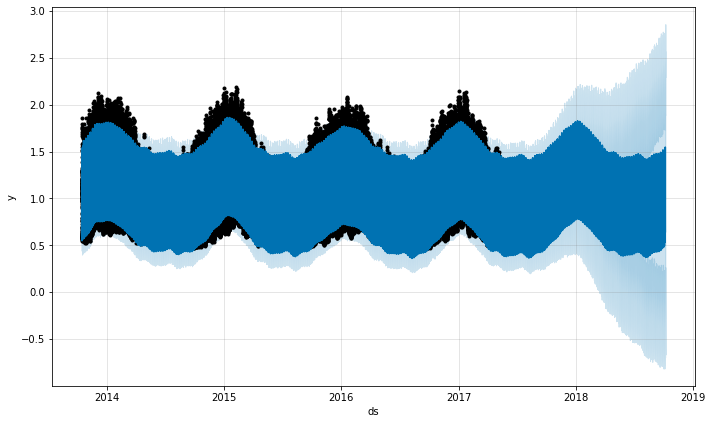

In [8]:
m=prophet
# creation of the future dataset that will include 7 day of forecast
# this 7 days period is passed to the by giving the frequence (30 minutes) and the number of samples 7*48
future = m.make_future_dataframe(periods=465*48, freq = '30T')
# creation of forecast dataset that will collect all the predcited value and the decomposition
forecast = m.predict(future)
fig = m.plot(forecast)
savefig(fig,'..\\..\\..\\figures\\prophet_RES1_full')

In [9]:
SMALL_SIZE = 10
MEDIUM_SIZE = 18
BIGGER_SIZE = 14

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## results analysis
- resusults are stored in the forecast dataset wich contains severals columns as it is shown below
- 'yhat' contains $ \hat{y}$  the estimated values at the datetime index contained in 'ds'
- results are the plotted by extracting samples conatined in forecast dataset matching the period 7*48

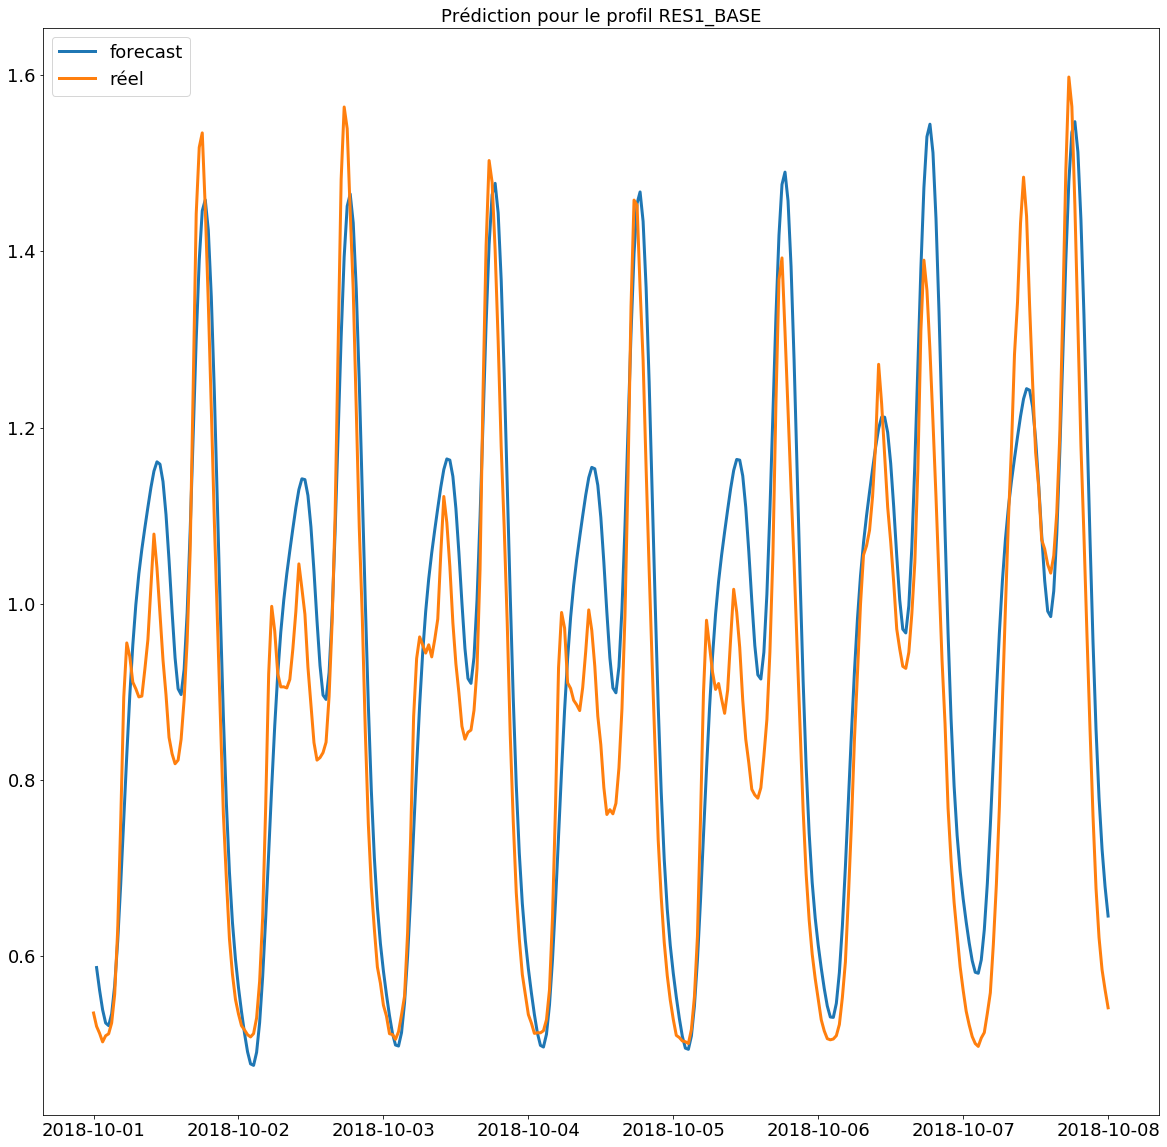

In [10]:
fig=plt.figure(figsize=(20,20))
id_max=forecast.shape[0]
# forecasted values ared stored at index contained in the index range [ id_max-(7*48+1) : id_max ]

plt.plot_date(forecast.iloc[id_max-7*48:id_max]['ds'],forecast.iloc[id_max-7*48:id_max]['yhat'],linestyle='-',linewidth=3,marker=None,label='forecast')
plt.plot_date(y_train.loc[date(2018,10,1):date(2018,10,8)].index,y_train.loc[date(2018,10,1):date(2018,10,8)]['RES1_BASE'],linestyle='-',linewidth=3,marker=None,label='réel')
plt.legend()
plt.title('Prédiction pour le profil RES1_BASE')
#plt.axvline(x=date(2017,4,30),color='green')
savefig(fig,'..\\..\\..\\figures\\prophet_RES1_Base_forecast_20181001-7j')

## Performance evaluation

In [11]:
from statsmodels.tools.eval_measures import rmse

Evaluation of the model with RMSE and MAPE metrics

In [12]:
# computation of metrics over the forecasted period using relative index from the end of the serie (id_max)
print('RMSE %0.2f' %rmse(forecast.iloc[id_max-(7*48+1):id_max]['yhat'],y_train.loc[date(2018,10,1):date(2018,10,8)]['RES1_BASE']))

print('MAPE %0.2f%%' %mape(np.array(y_train.loc[date(2018,10,1):date(2018,10,8)]['RES1_BASE']), np.array(forecast.iloc[id_max-(7*48+1):id_max]['yhat'])))

RMSE 0.13
MAPE 12.10%


# Introduction of seasonality

Following seasonality are introduced into the model

- working day / non  working day seasonality
- winter summer seasonality

A regressor is also added
- temperature regressor

In [13]:
#creation of the new dataset which contain new columns containing seasonality booleans
from code.seasons import seasonalize
arguments = {'mixed_columns': True, 'merge': True, 'pentecote': False, 'extradayoff': True, 
             'events' : {'world_cup_2014': ['12/06/2014', '13/07/2014'], 'rentree_2014': '02/09/2014', 'rentree_2015': '01/09/2015', 
                         'euro_cup_2016': ['10/06/2016', '10/07/2016'], 'rentree_2016': '01/09/2016', 'rentree_2017': '04/09/2017', 
                         'rentree_2018': '03/09/2018', 'world_cup_2018': ['14/06/2018', '15/07/2018']}}

df = seasonalize(y_RES1_BASE.loc[:date(2017,6,30)], **arguments).seasons_dataset()
df.special_days = df.special_days.astype(int)

In [14]:
df.tail()

,special_days,offpeak,peak,IDS,Horodate,Mois,y,RES11_BASE,PRO1_BASE,RES2_HC,RES2_HP,PRO2_HC,PRO2_HP,timestamp,ds,winter_on_work,winter_off_work,summer_on_work,summer_off_work
Horodate_UTC,,,,,,,,,,,,,,,,,,,
2017-06-29 22:00:00,0,True,False,65041,2017-06-29T00:00:00+02:00,6,0.685417,0.549869,0.547183,2.026307,0.189570,1.921576,0.195727,2017-06-29 22:00:00,2017-06-29 22:00:00,False,False,True,False
2017-06-29 22:30:00,0,True,False,65042,2017-06-29T00:30:00+02:00,6,0.631786,0.509246,0.533745,1.524985,0.187772,1.756901,0.190824,2017-06-29 22:30:00,2017-06-29 22:30:00,False,False,True,False
2017-06-29 23:00:00,0,True,False,65043,2017-06-29T01:00:00+02:00,6,0.592810,0.489143,0.533143,1.542738,0.132477,1.835221,0.131886,2017-06-29 23:00:00,2017-06-29 23:00:00,False,False,True,False
2017-06-29 23:30:00,0,True,False,65044,2017-06-29T01:30:00+02:00,6,0.564561,0.443937,0.515492,1.600243,0.089446,1.944258,0.086456,2017-06-29 23:30:00,2017-06-29 23:30:00,False,False,True,False
2017-06-30 00:00:00,0,True,False,65045,2017-06-29T02:00:00+02:00,6,0.533019,0.436021,0.507970,1.531084,0.030767,2.033156,0.026017,2017-06-30 00:00:00,2017-06-30 00:00:00,False,False,True,False


## Regressor is added to the dataset

In [15]:
# copy of the temperature (columns 18 from X_train) is added to the dataset in column 'temp'
df['temp'] = X_train.iloc[0:,19:20]

df.head()

,special_days,offpeak,peak,IDS,Horodate,Mois,y,RES11_BASE,PRO1_BASE,RES2_HC,RES2_HP,PRO2_HC,PRO2_HP,timestamp,ds,winter_on_work,winter_off_work,summer_on_work,summer_off_work,temp
Horodate_UTC,,,,,,,,,,,,,,,,,,,,
2013-10-13 22:00:00,0,True,False,1,2013-10-13T00:00:00+02:00,10,0.791405,0.698925,NaN,2.780413,0.346364,NaN,NaN,2013-10-13 22:00:00,2013-10-13 22:00:00,False,False,False,True,13.5
2013-10-13 22:30:00,0,True,False,2,2013-10-13T00:30:00+02:00,10,0.693700,0.722778,NaN,2.301527,0.375439,NaN,NaN,2013-10-13 22:30:00,2013-10-13 22:30:00,False,False,False,True,13.5
2013-10-13 23:00:00,0,True,False,3,2013-10-13T01:00:00+02:00,10,0.648565,0.678717,NaN,2.361320,0.268125,NaN,NaN,2013-10-13 23:00:00,2013-10-13 23:00:00,False,False,False,True,13.5
2013-10-13 23:30:00,0,True,False,4,2013-10-13T01:30:00+02:00,10,0.621059,0.668509,NaN,2.567490,0.192953,NaN,NaN,2013-10-13 23:30:00,2013-10-13 23:30:00,False,False,False,True,13.5
2013-10-14 00:00:00,0,True,False,5,2013-10-13T02:00:00+02:00,10,0.612245,0.700487,NaN,2.563460,0.075701,NaN,NaN,2013-10-14 00:00:00,2013-10-14 00:00:00,False,False,True,False,13.5


In [16]:
X_full=pd.concat([X_train,X_test],axis=0,sort=True).sort_index()

def weather_temp(df):
    columns = list(X_full.columns.values.tolist()) 
    if isinstance(df.index, pd.DatetimeIndex):
        list_date = df.index.tolist()
        count = 0
        for d in list_date:
            df.at[d, 'temp'] = X_full.loc[d,columns[19]]
            count = count + 1
    return df

## Creation of the Prophet model with custom seasonality an regressor
internal daily seasonality is desactivated

In [17]:
m = Prophet(daily_seasonality=False)

m.add_seasonality(name='winter_on_work', period=1, fourier_order=12, condition_name='winter_on_work')
m.add_seasonality(name='winter_off_work', period=1, fourier_order=12, condition_name='winter_off_work')
m.add_seasonality(name='summer_on_work', period=1, fourier_order=12, condition_name='summer_on_work')
m.add_seasonality(name='summer_off_work', period=1, fourier_order=12, condition_name='summer_off_work')

m.add_regressor(name='temp')
m.add_regressor(name='special_days')
# m.add_regressor(name='offpeak_hours')

Model training

In [18]:
m.fit(df)


### Preparation of future dataset for the forecast
creation of the seasonality and regressors columns

In [19]:
future = m.make_future_dataframe(periods=7*48, freq = '30T')

future['id']=future.index
future.index=future['ds']

future=seasonalize(future, **arguments).seasons_dataset()
future.special_days = future.special_days.astype(int)

future = weather_temp(future)
future.head()

# calendar.Dataframe(future)
# future=calendar.prophet_days_onoff()
future.index=future['id']
future=future.drop(["id"],axis=1)
future.head()

KeyError: Timestamp('2017-07-01 22:00:00')

## Forecast calculation
results are the plotted :
- components of the forecast :  trend, yealry seasonality, weekly seasonality, daily custom sesonality, regressor
- forecasted serie

In [ ]:

forecast = m.predict(future)

fig = m.plot_components(forecast)

fig = m.plot(forecast)

# Focus on the forecast and model evaluation

In [ ]:
fig=plt.figure(figsize=(20,20))
id_max=forecast.shape[0]
plt.plot_date(forecast.iloc[id_max-(7*48+1):id_max]['ds'],forecast.iloc[id_max-(7*48+1):id_max]['yhat'],linestyle='-',marker=None)
plt.plot_date(y_train.loc[date(2017,4,30):date(2017,5,7)].index,y_train.loc[date(2017,4,30):date(2017,5,7)]['RES1_BASE'],linestyle='-',marker=None)

In [ ]:
print('RMSE',rmse(forecast.iloc[id_max-(7*48+1):id_max]['yhat'],y_train.loc[date(2017,4,30):date(2017,5,7)]['RES1_BASE']))

print('MAPE %0.2f%%' %mape(np.array(y_train.loc[date(2017,4,30):date(2017,5,7)]['RES1_BASE']), np.array(forecast.iloc[id_max-(7*48+1):id_max]['yhat'])))

# Comparison of forecasted and real daily profiles

In [ ]:
import pytz
from matplotlib.dates import (HourLocator, AutoDateLocator, DateFormatter,
                              ConciseDateFormatter, rrulewrapper, RRuleLocator, drange)


paris=pytz.timezone('Europe/Paris')
locator = AutoDateLocator()
formatter=ConciseDateFormatter(locator,tz=paris)


fig=plt.figure(figsize=(30,30)) 
for i in range(7) :
        
        ax=fig.add_subplot(3,3,i+1)
        ax.plot_date(forecast.iloc[id_max-((7-i)*48+1):id_max-((6-i)*48+1)]['ds'],forecast.iloc[id_max-((7-i)*48+1):id_max-((6-i)*48+1)]['yhat'],linestyle='-',marker=None);
        ax.plot_date(y_train.loc[date(2017,4,30)+48*i*pd.Timedelta('30m'):date(2017,4,30)+48*(i+1)*pd.Timedelta('30m')].index,
                     y_train.loc[date(2017,4,30)+48*i*pd.Timedelta('30m'):date(2017,4,30)+48*(i+1)*pd.Timedelta('30m')]['RES1_BASE'],linestyle='-',marker=None)
        ax.xaxis.set_major_formatter(formatter)
        ax.xaxis.set_tick_params(rotation=30, labelsize=10)
        ax.set_title(date(2017,4,30)+48*i*pd.Timedelta('30m'),fontsize=10)


In [ ]:
df.tail()

## Regressor is added to the dataset

In [ ]:
# copy of the temperature (columns 18 from X_train) is added to the dataset in column 'temp'
df['temp'] = X_train.iloc[0:,18:19]

df.head()

In [ ]:
def weather_temp(df):
    columns = list(X_train.columns.values.tolist()) 
    if isinstance(df.index, pd.DatetimeIndex):
        list_date = df.index.tolist()
        count = 0
        for d in list_date:
            df.at[d, 'temp'] = X_train.loc[d,columns[18]]
            count = count + 1
    return df

## Creation of the Prophet model with custom seasonality an regressor
internal daily seasonality is desactivated

In [ ]:
m = Prophet(daily_seasonality=False)

m.add_seasonality(name='winter_on_work', period=1, fourier_order=12, condition_name='winter_on_work')
m.add_seasonality(name='winter_off_work', period=1, fourier_order=12, condition_name='winter_off_work')
m.add_seasonality(name='summer_on_work', period=1, fourier_order=12, condition_name='summer_on_work')
m.add_seasonality(name='summer_off_work', period=1, fourier_order=12, condition_name='summer_off_work')

m.add_regressor(name='temp')
m.add_regressor(name='special_days')
# m.add_regressor(name='offpeak_hours')


Model training

In [ ]:
m.fit(df)


### Preparation of future dataset for the forecast
creation of the seasonality and regressors columns

In [ ]:
future = m.make_future_dataframe(periods=7*48, freq = '30T')

future['id']=future.index
future.index=future['ds']

future=seasonalize(future, **arguments).seasons_dataset()
future.special_days = future.special_days.astype(int)

future = weather_temp(future)
future.head()

# calendar.Dataframe(future)
# future=calendar.prophet_days_onoff()
future.index=future['id']
future=future.drop(["id"],axis=1)
future.head()

## Forecast calculation
results are the plotted :
- components of the forecast :  trend, yealry seasonality, weekly seasonality, daily custom sesonality, regressor
- forecasted serie

In [ ]:

forecast = m.predict(future)

fig = m.plot_components(forecast)

fig = m.plot(forecast)

# Focus on the forecast and model evaluation

In [ ]:
fig=plt.figure(figsize=(20,20))
id_max=forecast.shape[0]
plt.plot_date(forecast.iloc[id_max-(7*48+1):id_max]['ds'],forecast.iloc[id_max-(7*48+1):id_max]['yhat'],linestyle='-',marker=None)
plt.plot_date(y_train.loc[date(2017,4,30):date(2017,5,7)].index,y_train.loc[date(2017,4,30):date(2017,5,7)]['RES1_BASE'],linestyle='-',marker=None)

In [ ]:
print('RMSE',rmse(forecast.iloc[id_max-(7*48+1):id_max]['yhat'],y_train.loc[date(2017,4,30):date(2017,5,7)]['RES1_BASE']))

print('MAPE %0.2f%%' %mape(np.array(y_train.loc[date(2017,4,30):date(2017,5,7)]['RES1_BASE']), np.array(forecast.iloc[id_max-(7*48+1):id_max]['yhat'])))

# Comparison of forecasted and real daily profiles

In [ ]:
import pytz
from matplotlib.dates import (HourLocator, AutoDateLocator, DateFormatter,
                              ConciseDateFormatter, rrulewrapper, RRuleLocator, drange)


paris=pytz.timezone('Europe/Paris')
locator = AutoDateLocator()
formatter=ConciseDateFormatter(locator,tz=paris)


fig=plt.figure(figsize=(30,30)) 
for i in range(7) :
        
        ax=fig.add_subplot(3,3,i+1)
        ax.plot_date(forecast.iloc[id_max-((7-i)*48+1):id_max-((6-i)*48+1)]['ds'],forecast.iloc[id_max-((7-i)*48+1):id_max-((6-i)*48+1)]['yhat'],linestyle='-',marker=None);
        ax.plot_date(y_train.loc[date(2017,4,30)+48*i*pd.Timedelta('30m'):date(2017,4,30)+48*(i+1)*pd.Timedelta('30m')].index,
                     y_train.loc[date(2017,4,30)+48*i*pd.Timedelta('30m'):date(2017,4,30)+48*(i+1)*pd.Timedelta('30m')]['RES1_BASE'],linestyle='-',marker=None)
        ax.xaxis.set_major_formatter(formatter)
        ax.xaxis.set_tick_params(rotation=30, labelsize=10)
        ax.set_title(date(2017,4,30)+48*i*pd.Timedelta('30m'),fontsize=10)